In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, matutils
import nltk
pd.set_option('display.max_rows', 2000)


In [34]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
import re
docs_df = pd.read_pickle('docs_raw.pkl')
docs_df['ep_name']=docs_df.ep_name.apply(lambda x: x.strip('- '))
docs_df['no_char']=docs_df.lines.apply(lambda x: len(x))

In [5]:
jim_df =docs_df[docs_df.character=='Jim']
jim_df.drop(columns=['character'], inplace=True)
jim_df['spacy_doc']=list(nlp.pipe(jim_df.lines))

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-5-3ba66dfcc542>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jim_df['spacy_doc']=list(nlp.pipe(jim_df.lines))


In [119]:
clean_docs = [[token.lemma_.lower() for token in doc
              if (not token.is_stop and not token.is_punct and not token.like_num )&
              (token.pos_=='NOUN' or token.pos_=='PROPN' or
               token.pos_=="X")] for doc in jim_df.spacy_doc]
jim_df['clean_doc']=[' '.join(doc) for doc in clean_docs]
jim_df['clean_doc']=jim_df['clean_doc'].apply(lambda x: x.replace('kev ', 'kevin '))

<ipython-input-119-4fa4700a16b5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jim_df['clean_doc']=[' '.join(doc) for doc in clean_docs]
<ipython-input-119-4fa4700a16b5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jim_df['clean_doc']=jim_df['clean_doc'].apply(lambda x: x.replace('kev ', 'kevin '))


In [36]:
#determine topics
def get_topics(n_topics, n_terms, model, term_list):
    for i in range(n_topics):
        topic_weights_full = np.argsort(model.components_[i])
        top_terms =  topic_weights_full[
            len(topic_weights_full): (len(topic_weights_full)-(n_terms+1)):-1]
    
    # get term indices, sorted (descending) by topic weights    
        topic_weights = np.array(model.components_[i][top_terms[0]])
        for i in top_terms[1:]:
            topic_weights= np.append(topic_weights, model.components_[0][i])
    # use the `terms` array to get the actual top terms

            term_names = [terms[item] for item in top_terms]
        print(i, topic_weights, term_names)

In [197]:
stopwords = nltk.corpus.stopwords.words('english')
words_to_cut =['look', 'thank', 'come', 'new', 'thing', 'get', 'great', 'good',
               'day', 'let', 'say', 'start', 'leave', 'little', 'year', 'guy',
              'phone', 'wait', 'sight', 'sign', 'tell', 'work', 'ok', 'room', 'people', 'mm', 'hmm',
              'hour', 'room', 'hour', 'way', 'fact', 'time', 'hand', 'thing', 'mr', 'ahh', 'co', 'mmm', 'cell',
              'go', 'cap', 'car', 'need', 'night', 'kay', 'ohh', 'ow','uh', 'uhm', 'umm', 'turn', 'lot', 'month',
               'place', 'laughs', 'point', 'chuckle', 'sigh', 'laughs', 'tomorrow', 'lunch', 'minute',
               'engagement', 'today', 'man', 'camera', 'door', 'week', 'glass', 'eye', 'ya', 'help', 'end',
               'watch', 'laugh', 'exhale', 'smile', 'god', 'stuff', 'feeling', 'week', 'month']
stopwords.extend(words_to_cut)

In [198]:
cv = CountVectorizer(lowercase=False, stop_words = stopwords, max_df=0.95) 
X=cv.fit_transform(jim_df.clean_doc)
doc_term_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
terms = np.array(doc_term_df.columns.to_list())

In [127]:
tfidf = TfidfVectorizer(stop_words = stopwords,
                       lowercase = False, min_df=0.07) 
X_idf=tfidf.fit_transform(jim_df.clean_doc)
doc_term_idf_df = pd.DataFrame(X_idf.toarray(), columns=tfidf.get_feature_names())
terms_idf = np.array(doc_term_idf_df.columns.to_list())

In [141]:
len(terms)

1206

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(doc_term_df)

get_topics(5, 10, pca, terms)

0 [0.66249475 0.63642921 0.26245693 0.15752394 0.10298768 0.0956749
 0.06892495 0.06615804 0.06222742 0.05011166] ['eye', 'morning', 'player', 'job', 'michael', 'phyllis', 'week', 'game', 'copy', 'andy']
37 [0.45545423 0.10298768 0.05011166 0.00971697 0.15752394 0.03933513
 0.04550341 0.04766093 0.0956749  0.00833164] ['eye', 'michael', 'andy', 'door', 'job', 'joke', 'karen', 'wedding', 'phyllis', 'kevin']
14 [ 0.59828055  0.0956749   0.06892495 -0.00525766 -0.00197591 -0.01946828
  0.02257129  0.05011166  0.03134247  0.06222742] ['morning', 'phyllis', 'week', 'jo', 'question', 'stuff', 'boss', 'andy', 'conference', 'copy']
34 [ 0.40093955  0.05011166  0.04766093  0.10298768  0.26245693 -0.00525766
  0.06222742 -0.00197591 -0.02844507  0.04550341] ['phyllis', 'andy', 'wedding', 'michael', 'player', 'jo', 'copy', 'question', 'meredith', 'karen']
27 [ 0.53014483  0.00971697 -0.05882778  0.0956749  -0.00197591 -0.00986257
 -0.01346718  0.03933513  0.00256638  0.01773402] ['job', 'door', '

In [128]:
from sklearn.decomposition import NMF
nmf = NMF(5)
nmf.fit(doc_term_idf_df)
get_topics(5, 10, nmf, terms_idf)

22 [1.58943024 0.40750763 0.3068156  0.21100376 0.14453914 0.13829914
 0.13763435 0.13540088 0.12324021 0.11336282] ['michael', 'office', 'boss', 'number', 'jim', 'bathroom', 'pam', 'scott', 'ryan', 'friend']
24 [1.54231465 0.14453914 0.01034246 0.         0.13763435 0.
 0.         0.         0.09354405 0.        ] ['dwight', 'jim', 'manager', 'jo', 'pam', 'break', 'wedding', 'desk', 'job', 'game']
2 [1.37884309 0.         0.         0.0055718  0.11336282 0.06694098
 0.07350889 0.         0.04966414 0.        ] ['pam', 'copy', 'kevin', 'question', 'friend', 'mom', 'girl', 'tonight', 'laugh', 'art']
65 [1.30336938 0.         0.         0.         0.106402   0.
 0.00448419 0.21100376 0.         0.        ] ['karen', 'game', 'couple', 'wedding', 'company', 'ring', 'video', 'number', 'school', 'team']
44 [0.70904051 0.         0.         0.40750763 0.09998805 0.09687678
 0.         0.07406678 0.00547483 0.        ] ['idea', 'andy', 'desk', 'office', 'party', 'sale', 'meeting', 'meredith', 

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [325]:
nmf2_df = pd.DataFrame(nmf.transform(doc_term_idf_df), columns=['family', 'job', 'sales', 'sex', 'childhood/toby'])
modeled_df = pd.merge(mike_df.iloc[:, [1,2]].reset_index(), nmf2_df, right_index=True, left_index=True)

,index,episode_no,ep_name,family,job,sales,sex,childhood/toby
0,0,"(2, 1)",The Dundies,0.235468,0.058781,0.000000,0.102885,0.102328
1,63,"(2, 2)",Sexual Harassment,0.069669,0.000000,0.503103,0.000000,0.134432
2,124,"(2, 21)",Conflict Resolution,0.233772,0.000000,0.000615,0.154881,0.004751
3,138,"(2, 12)",The Injury,0.037537,0.000000,0.008295,0.215196,0.306821
4,23,"(2, 14)",The Carpet,0.000000,0.065144,0.689270,0.015787,0.000000
5,188,"(2, 18)",Take Your Daughter to Work Day,0.029631,0.033644,0.000000,0.000000,0.388167
6,111,"(2, 6)",The Fight,0.000000,0.000000,0.273980,0.211553,0.136153
7,170,"(2, 5)",Halloween,0.071961,0.000000,0.000000,0.421649,0.000000
8,43,"(2, 9)",E-Mail Surveillance,0.306742,0.124969,0.000000,0.000000,0.000000
9,93,"(2, 16)",Valentine's Day,0.141389,0.174549,0.000000,0.000000,0.000000


In [326]:
modeled_df['season']=modeled_df.episode_no.apply(lambda x: x[0])
by_season = modeled_df.groupby('season', as_index=False)[['family', 'job', 'sales', 'sex', 'childhood/toby']].mean()
by_season

,season,family,job,sales,sex,childhood/toby
0,2,0.102379,0.056357,0.134115,0.113381,0.109834
1,3,0.140061,0.131896,0.020565,0.064511,0.044857
2,4,0.140401,0.020457,0.009585,0.187583,0.083500
3,5,0.074702,0.206766,0.015849,0.059336,0.051950
4,6,0.048728,0.076378,0.003501,0.163949,0.169727
5,7,0.050779,0.039600,0.078221,0.125726,0.145847


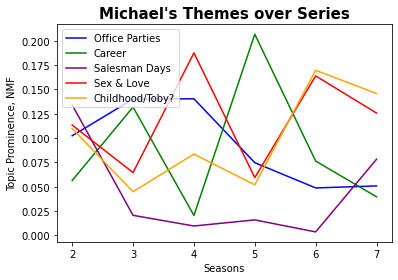

In [343]:
plt.plot(by_season['season'], by_season['family'], color='b')
plt.plot(by_season['season'], by_season['job'], color='g')
plt.plot(by_season['season'], by_season['sales'], color='purple')
plt.plot(by_season['season'], by_season['sex'], color='r')
plt.plot(by_season['season'], by_season['childhood/toby'], color='orange')
plt.title("Michael's Themes over Series", fontsize=15, weight='bold')
plt.legend(['Office Parties', 'Career', 'Salesman Days','Sex & Love', 'Childhood/Toby?'], loc=2)
plt.xlabel('Seasons')
plt.ylabel('Topic Prominence, NMF')
plt.savefig('mike_themes.png', transparent=True)
plt.show()


In [ ]:
print(nmf2_df.shape, mike_df.iloc[:, [1,2]].shape)

In [308]:
from sklearn.decomposition import NMF
nmf = NMF(5)
nmf.fit(doc_term_df)

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(n_components=5)

In [90]:
corpus = matutils.Sparse2Corpus(X_idf.transpose())
id2word = dict((v,k) for k,v in tfidf.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=100)


In [92]:
lda.print_topics()

[(0,
  '0.091*"pam" + 0.047*"sale" + 0.044*"michael" + 0.042*"dwight" + 0.038*"mom" + 0.033*"game" + 0.030*"money" + 0.026*"desk" + 0.025*"tonight" + 0.025*"copy"'),
 (1,
  '0.054*"michael" + 0.053*"dwight" + 0.043*"manager" + 0.035*"jim" + 0.034*"office" + 0.034*"kevin" + 0.030*"boss" + 0.027*"andy" + 0.026*"desk" + 0.024*"idea"'),
 (2,
  '0.049*"karen" + 0.038*"number" + 0.028*"company" + 0.027*"game" + 0.026*"desk" + 0.025*"idea" + 0.023*"jo" + 0.022*"kev" + 0.022*"glass" + 0.021*"eye"'),
 (3,
  '0.086*"michael" + 0.064*"dwight" + 0.058*"pam" + 0.037*"office" + 0.032*"party" + 0.032*"karen" + 0.028*"jim" + 0.025*"job" + 0.022*"number" + 0.022*"meredith"'),
 (4,
  '0.052*"idea" + 0.044*"andy" + 0.041*"face" + 0.035*"jim" + 0.035*"pam" + 0.035*"dwight" + 0.031*"stuff" + 0.029*"wedding" + 0.026*"morning" + 0.026*"music"')]

In [257]:
from corextopic import corextopic as ct
topic_model = ct.Corex(n_hidden=6, words=[i for i in terms], seed=1)
topic_model.fit(X, words=[i for i in terms], docs=jim_df.clean_doc, 
                anchors=[['pam', 'love', 'wedding'],['dwight', 'plan', 'reception','prank'],
                         ['job', 'sale', 'paper', 'commission'],['michael']],
               anchor_strength=9)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{n}: {", ".join(topic_words)}')

0: wedding, love, pam, mifflin, dunder, sound, beesley, weekend, flower, advice
1: dwight, plan, prank, halpert, reason, experience, photo, meeting, jim, soda
2: sale, job, paper, commission, charge, erin, information, school, break, favor
3: michael, party, scott, ryan, girl, business, kid, home, phyllis, half
4: jo, cake, mistake, surprise, gabe, attention, finger, stanley, department, gesture
5: kiss, clock, court, food, tv, nope, chicken, light, kind, player


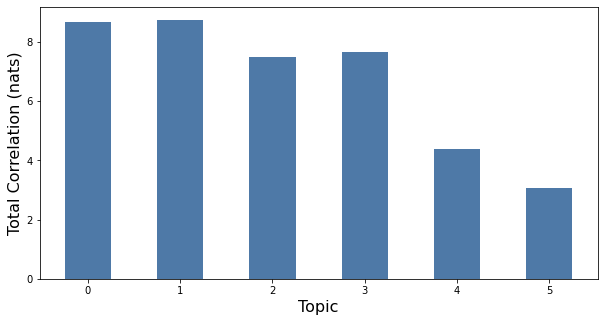

In [258]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [248]:
topic_columns = ['pam', 'pranks', 'career']
ct_df = pd.DataFrame(topic_model.p_y_given_x, columns=topic_columns)
ct_pred_full = pd.merge(jim_df.iloc[:, [0,1]],
                        ct_df, right_index=True, left_index=True)
ct_pred_full = ct_pred_full.sort_values('episode_no')
ct_pred_full.reset_index(inplace=True, drop=True)


ValueError: Shape of passed values is (66, 6), indices imply (66, 3)

In [235]:
ct_pred_full.sort_values('pranks', ascending=False)

,episode_no,ep_name,pam,pranks,career
0,"(2, 1)",The Dundies,0.000001,0.999999,0.000001
45,"(6, 7)",The Lover,0.999999,0.999999,0.000001
29,"(5, 1)",Weight Loss (Parts 1&2),0.999999,0.999999,0.000001
34,"(5, 11)",Moroccan Christmas,0.000462,0.999999,0.000001
38,"(5, 24)",Heavy Competition,0.999999,0.999999,0.999999
39,"(5, 25)",Broke,0.000001,0.999999,0.000001
40,"(5, 27)",Cafe Disco,0.999999,0.999999,0.000001
41,"(5, 28)",Company Picnic,0.000001,0.999999,0.000001
43,"(6, 4)",Niagara (Parts 1&2),0.000001,0.999999,0.000001
47,"(6, 10)",m*rder,0.000001,0.999999,0.999999


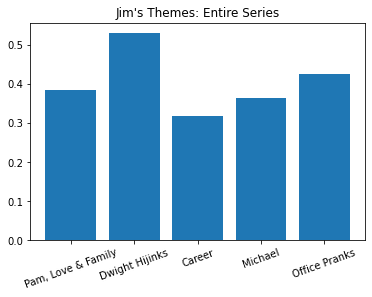

In [176]:
topic_columns = [1, 2, 3, 4, 5]
all_time = []
for i in range(2,7):
    all_time.append(np.mean(ct_pred_full.iloc[:, i]))


plt.bar(topic_columns, all_time)
plt.xticks( [1, 2, 3,4,5], 
           labels= ['Pam, Love & Family', 'Dwight Hijinks', 'Career', 'Michael', 'Office Pranks'],
           rotation=20)
plt.title("Jim's Themes: Entire Series")
plt.show()

In [184]:
ct_pred_full['character']='jim'
ct_pred_full.to_csv('to_tableau/jim_topics.csv')
cv_counts = CountVectorizer(lowercase=False, stop_words = stopwords, max_features=50) 
X_counts=cv_counts.fit_transform(jim_df.clean_doc)
doc_term_df_counts = pd.DataFrame(X_counts.toarray(), columns=cv_counts.get_feature_names())
terms_counts = np.array(doc_term_df.columns.to_list())

In [185]:
jim_df.to_csv('to_tableau/jim_lines.csv')

In [186]:
rows=[]
words = doc_term_df_counts.columns.tolist()
counts = []
for i in words:
    counts.append(doc_term_df_counts[i].sum())

top_words = list(zip(words, counts))
for i in top_words:
    row_dict = {'word': i[0], 'count': i[1]}
    rows.append(row_dict)
dwight_counts = pd.DataFrame(rows)
dwight_counts.sort_values('count', ascending=False, inplace=True)  
dwight_counts.to_csv('to_tableau/jim_counts.csv')